In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import norm

Ingreso empresas que quiero trabajar

[*********************100%***********************]  2 of 2 completed


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

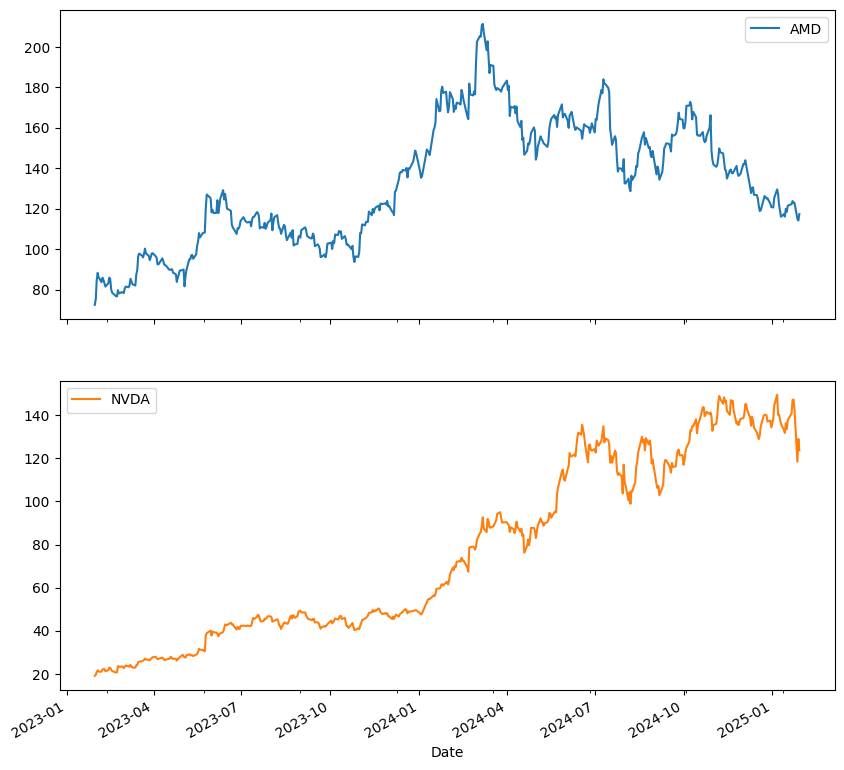

In [ ]:
#Empresas = ['NVDA','GGAL','MSFT','AMD','TSLA']
Empresas = ['NVDA','AMD']
datos = yf.download(Empresas, start = '2023-01-30', end='2025-01-30')# se puede agregar para que traiga los ultimos 2 años
datos_cierre = datos['Close']
#datos_cierre
datos_cierre.head()
datos_cierre.plot(figsize=(10,10), subplots=True) # falta agregar titulo y fechas aprox

Rendimientos diarios

In [ ]:
rend_d = datos_cierre.pct_change()
rend_d.head()

Ticker,AMD,NVDA
Date,,
2023-01-03,NaN,NaN
2023-01-04,0.009997,0.030318
2023-01-05,-0.036035,-0.032816
2023-01-06,0.026151,0.041641
2023-01-09,0.051282,0.051753


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

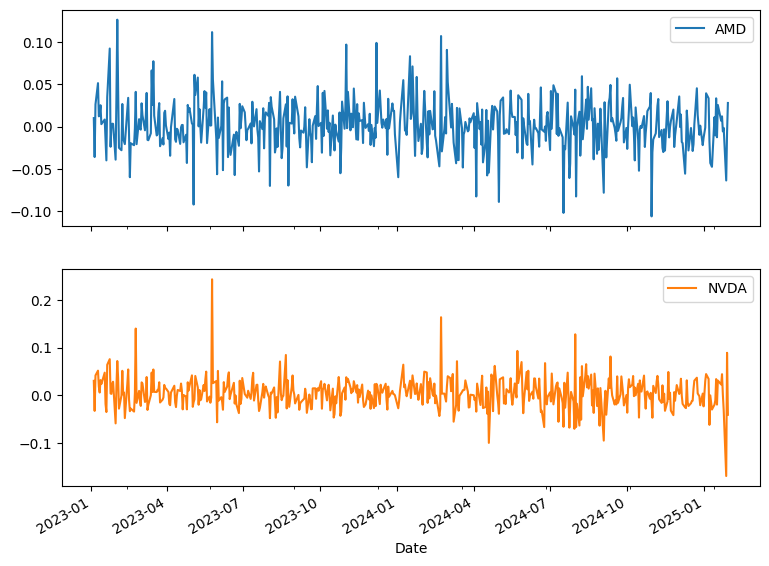

In [ ]:
rend_d.plot(figsize=(9,7), subplots=True)

Rendimiento Promedio anualizado

In [ ]:
rend_anual = ((1 + rend_d.mean())**252) -1
print('Rendiminetos anualizados')
rend_anual

Rendiminetos anualizados


,0
Ticker,
AMD,0.500614
NVDA,2.256225


Varianza Anualizada

In [ ]:
Var_d = rend_d.var()
Var_anual = Var_d * (252**0.5)
print('Varianza anualizada')
Var_anual

Varianza anualizada


,0
Ticker,
AMD,0.014151
NVDA,0.017174


Calculamos la matriz de varianzas y covarianzas de los activos

In [ ]:
covarianzas = rend_d.cov()
covarianzas_diarias = rend_d.cov()
covarianzas_anual = covarianzas * 252
rendimientos_anual = rend_d.mean() * 252

In [ ]:
n_random = 100
rendimientoL = []
riesgoL = []

In [ ]:
for i in range(n_random):
  A1 = i / (n_random -1)
  A2 = 1 - A1
  pesos = np.array([float(A1), float(A2)])
  rendimiento = np.dot(pesos, rendimientos_anual)
  riesgo = np.sqrt(np.dot(pesos.T, np.dot(covarianzas_anual, pesos)))
  riesgoL.append(riesgo)
  rendimientoL.append(rendimiento)

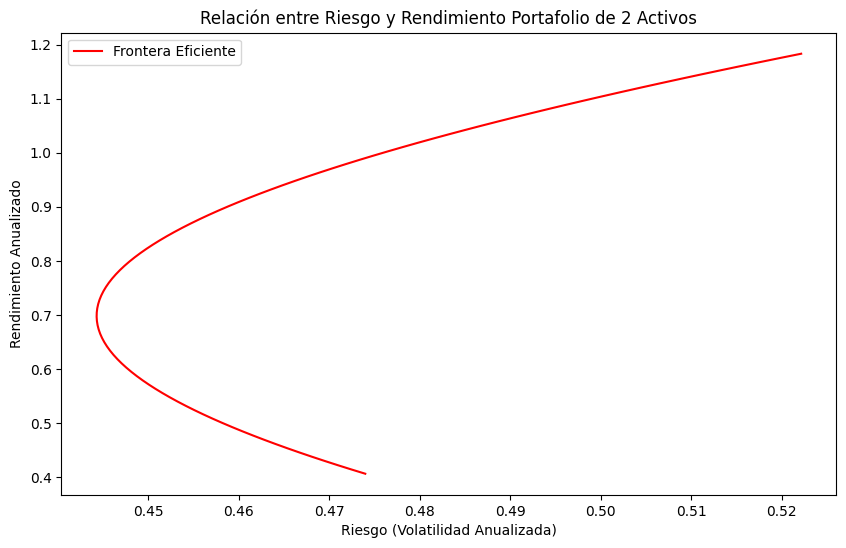

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(riesgoL, rendimientoL, label='Frontera Eficiente', color='red')
plt.title("Relación entre Riesgo y Rendimiento Portafolio de 2 Activos")
plt.xlabel("Riesgo (Volatilidad Anualizada)")
plt.ylabel("Rendimiento Anualizado")
plt.legend(loc='upper left')
plt.show()

Minimizacion de Varianza

In [ ]:
def Varianza_min(A , cov):
  return np.dot(A.T, np.dot(cov , A))

In [ ]:
Restricciones = (
    {"type": "eq", "fun": lambda A: np.sum(A) - 1}
    )

Posiciones entre 0 y 1 , no se puede estar Short

In [ ]:
Limites = [(0,1) for _ in range(len(covarianzas))]

In [ ]:
## pesos iniciales : Distribucion 50% c/u
pesos_iniciales = np.array([1/len(covarianzas)]*len(covarianzas))

In [ ]:
resultado = minimize(
      Varianza_min,
      pesos_iniciales,
      args=(covarianzas_anual,),
      constraints=Restricciones,
      bounds = Limites,
      method='SLSQP'
)

In [ ]:
Min_var = resultado.x
print(Min_var)
rend_min_var = np.dot(Min_var, rendimientos_anual)
print(rend_min_var)
riesgo_min_var = np.sqrt(np.dot(Min_var.T, np.dot(covarianzas_anual, Min_var)))
print(riesgo_min_var)

[0.62425924 0.37574076]
0.6982035321992497
0.4442687498265062


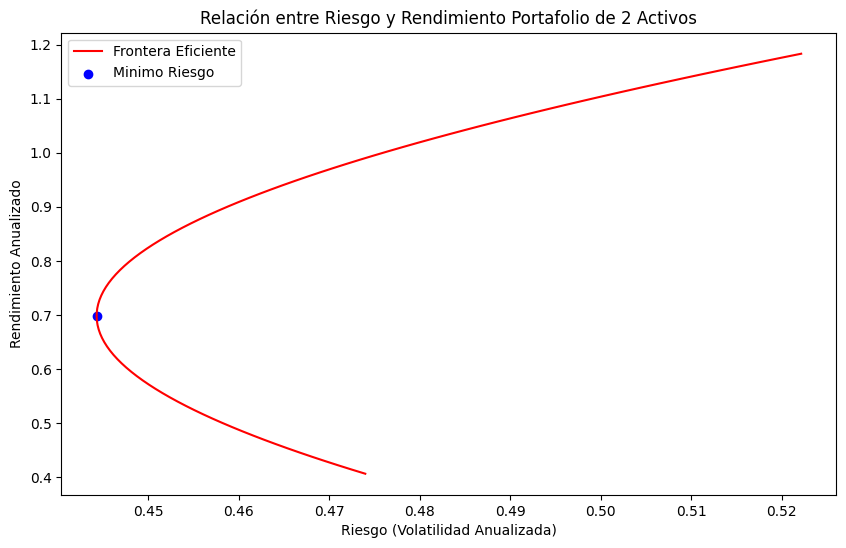

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(riesgoL, rendimientoL, label='Frontera Eficiente', color='red')

plt.scatter(riesgo_min_var, rend_min_var, label='Minimo Riesgo', color='blue')

plt.title("Relación entre Riesgo y Rendimiento Portafolio de 2 Activos")
plt.xlabel("Riesgo (Volatilidad Anualizada)")
plt.ylabel("Rendimiento Anualizado")
plt.legend(loc='upper left')
plt.show()

In [ ]:
tasa_libre = 0.04
#rendimiento y riesgo del portfolio
def rendimiento_riesgo(pesos, rendimientos, covarianzas):
    rendimiento = np.sum(rendimientos * pesos)
    riesgo = np.sqrt(np.dot(pesos.T, np.dot(covarianzas, pesos)))
    return rendimiento, riesgo

In [ ]:
#funcion objetivo >MAX Ratio sharpe
def ratio_sharpe(pesos, rendimientos, covarianzas, tasa_libre):
    rendimiento, riesgo = rendimiento_riesgo(pesos, rendimientos, covarianzas)
    return -(rendimiento - tasa_libre) / riesgo # el negativo adelante indica Minimizacion.

In [ ]:
resultado_sharpe = minimize(
      ratio_sharpe,
      pesos_iniciales,
      args=(rendimientos_anual, covarianzas_anual, tasa_libre),
      constraints=Restricciones,
      bounds = Limites,
      method='SLSQP'
)

In [ ]:
res_sharpe = resultado_sharpe.x
print(res_sharpe)
rendimiento_sharpe, riesgo_sharpe = rendimiento_riesgo(res_sharpe, rendimientos_anual, covarianzas_anual)
riesgo_sharpe = np.sqrt(np.dot(res_sharpe.T, np.dot(covarianzas_anual, res_sharpe)))


[0. 1.]


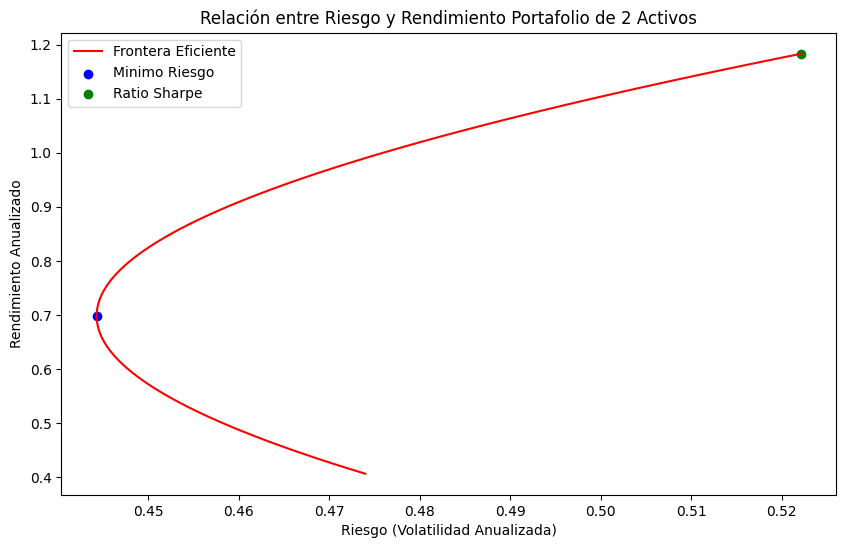

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(riesgoL, rendimientoL, label='Frontera Eficiente', color='red')

plt.scatter(riesgo_min_var, rend_min_var, label='Minimo Riesgo', color='blue')
plt.scatter(riesgo_sharpe, rendimiento_sharpe, label='Ratio Sharpe', color='green')

plt.title("Relación entre Riesgo y Rendimiento Portafolio de 2 Activos")
plt.xlabel("Riesgo (Volatilidad Anualizada)")
plt.ylabel("Rendimiento Anualizado")
plt.legend(loc='upper left')
plt.show()

Sortino ratio  #enfoque a desvio negativo

Ratio SORTINO

In [ ]:
retornos_diarios = datos_cierre.pct_change().dropna()

In [ ]:
#funcion rend anualizado
def f_rendimiento_anualizado(pesos , rendimiento):
    return np.dot(pesos, rendimiento.mean()) * 252

In [ ]:
#funcion de downside riesgo
def downside_risk(pesos, rendimineto):
  rend_portf = np.dot(rendimiento, pesos)
  downside = rend_portf[rend_portf < 0]
  if len(downside) == 0:
    return 0 ## cero si no hay perdidas
  downside_desvio = np.std(downside)
  return downside_desvio


In [ ]:
#Funcion Objetivo
def ratio_sortino(pesos, rendimiento, tasa_libre):
  rendimiento2 = f_rendimiento_anualizado(pesos, rendimiento)
  downside = downside_risk(pesos, rendimiento)
  if downside == 0:
    return np.inf
  return -(rendimiento2 - tasa_libre) / downside #minimizacion

In [ ]:
Restricciones = (
    {"type": "eq", "fun": lambda A: np.sum(A) - 1}
    )

In [ ]:
Limites = [(0,1) for _ in range(len(covarianzas))]

In [ ]:
pesos_iniciales = np.array([1/len(covarianzas)]*len(covarianzas))

In [ ]:
tasa_libre = 0.000

In [ ]:
resultado_sortino = minimize(
    ratio_sortino,
    pesos_iniciales,
    args=(rendimientos_anual, tasa_libre),
    constraints=Restricciones,
    bounds=Limites,
    method='SLSQP'
)

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [ ]:
resultado_sortino = minimize(
    ratio_sortino,
    pesos_iniciales,
    args=(retornos_diarios, tasa_libre),
    constraints=Restricciones,
    bounds=Limites,
    method='SLSQP'
)

In [ ]:
res_sortino = resultado_sortino.x
print(res_sortino)
print(res_sharpe)
print(Min_var)

[0.5 0.5]
[0. 1.]
[0.62425924 0.37574076]


In [ ]:
rendimiento_sortino, riesgo_sortino = rendimiento_riesgo(res_sortino, rendimientos_anual, covarianzas_anual)
riesgo_sortino = np.sqrt(np.dot(res_sortino.T, np.dot(covarianzas_anual, res_sortino)))

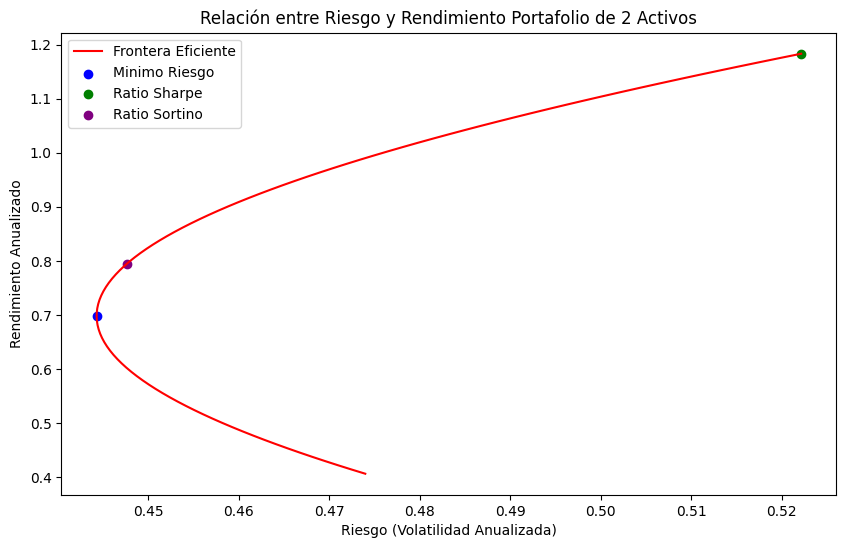

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(riesgoL, rendimientoL, label='Frontera Eficiente', color='red')

plt.scatter(riesgo_min_var, rend_min_var, label='Minimo Riesgo', color='blue')
plt.scatter(riesgo_sharpe, rendimiento_sharpe, label='Ratio Sharpe', color='green')
plt.scatter(riesgo_sortino, rendimiento_sortino, label='Ratio Sortino', color='purple')

plt.title("Relación entre Riesgo y Rendimiento Portafolio de 2 Activos")
plt.xlabel("Riesgo (Volatilidad Anualizada)")
plt.ylabel("Rendimiento Anualizado")
plt.legend(loc='upper left')
plt.show()

In [ ]:
datos2 = yf.download(Empresas, start = '2025-02-01', end='2025-05-10')
nvos_datos = datos2['Close']
nvos_datos.head()

[*********************100%***********************]  2 of 2 completed


Ticker,AMD,NVDA
Date,,
2025-02-03,114.269997,116.649277
2025-02-04,119.500000,118.639091
2025-02-05,112.010002,124.818520
2025-02-06,110.160004,128.668152
2025-02-07,107.559998,129.828049


In [ ]:
test = pd.DataFrame()
test['Minima_varianza'] = nvos_datos.pct_change().dot(Min_var)
test['Ratio sharpe'] = nvos_datos.pct_change().dot(res_sharpe)
test['Ratio sortino'] = nvos_datos.pct_change().dot(res_sortino)

In [ ]:
test = test.dropna()
test.head()

,Minima_varianza,Ratio sharpe,Ratio sortino
Date,,,
2025-02-04,0.034981,0.017058,0.031413
2025-02-05,-0.019556,0.052086,-0.005296
2025-02-06,0.001278,0.030842,0.007163
2025-02-07,-0.011347,0.009015,-0.007294
2025-02-10,0.027741,0.028728,0.027938


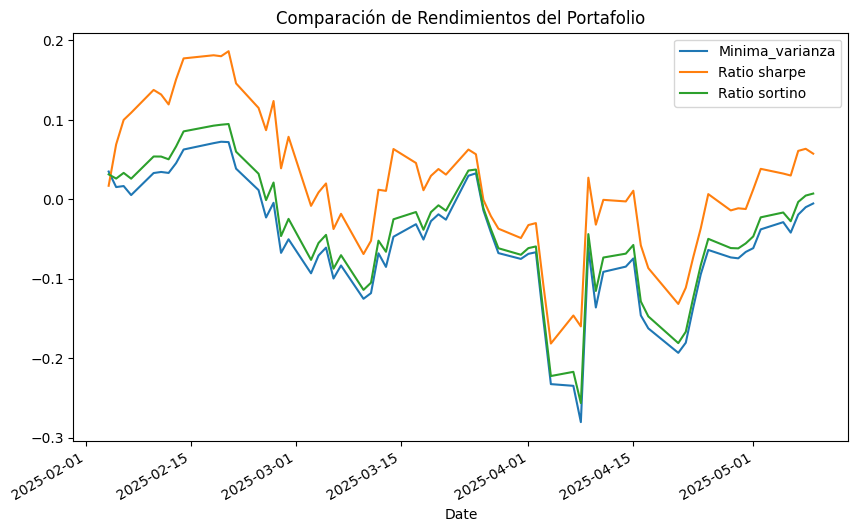

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
test.cumsum().plot(ax=ax)
ax.set_title("Comparación de Rendimientos del Portafolio")
fig.show()